# Svenskt Kvinnobiografiskt lexikon - SKBL part 3
    version part 3 - 2.7
 
 This [notebook](https://tinyurl.com/SKBLWDsynch) - latest run [diff WD / SKBL](https://github.com/salgo60/open-data-examples/blob/master/SKBL_new.csv)
  
  
  * SKBL see https://skbl.se/en  
    * example structured data from SKBL [GretaGarbo JSON](https://skbl.se/en/article/GretaGarbo.json)
    * video 
      * in [Swedish what we do today](https://youtu.be/LBx7XowzrJ0)
      * the vision with [Wikidata <-> SKBL](https://www.youtube.com/watch?v=HIHO-szkD1A)
    * [presentation](https://docs.google.com/presentation/d/1EvQHdzPsIA4hr2WuNXnbpsLHec2GS89b_pHvilO6xhQ/edit?usp=sharing) about start using Linked data at SKBL and have same as Wikidata 
  * [Wikidata:WikiProject_Sweden/Svenskt_kvinnobiografiskt_lexikon](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/Svenskt_kvinnobiografiskt_lexikon)
    
  
### Purpose
  * gets statistics about SKBL and compare number of articles produced with what The Swedish National archives [SBL biographies](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) has produced since 1918
  * check if SKBL has new articles created not added to [Wikidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-03-04 15:23:35.670841


#### Other sources we sync
* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 


### Links
* [video](https://www.youtube.com/watch?v=6jxH8MBIhvg) in Swedish about how SKBL deliver and work with Wikidata
  * Example how project Women in Red at en:Wikipedia automatic [creates dynamic lists of "missing" articles](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) that shows what in SKBL has an english article about a women but not have an english article in en:Wikipedia
    * see [version history](https://en.wikipedia.org/w/index.php?title=Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW&action=history) of list created
    * see en:Wikipedia articles [with a link to SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 680 articles using the [SKBL template](https://en.wikipedia.org/wiki/Template:SKBL)

Below we also use Wikidata to compare number of female articles produced
* [SKBL started 2018](https://skbl.se/en/about-skbl)
  * use a data driven approach with structured data
  * has swedish/english articles see [https://pageviews.toolforge.org/massviews/?platform=all-access&agent=user&source=category&range=this-year&subjectpage=0&subcategories=0&sort=views&direction=1&view=list&target=https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963 statistics en:Wikipedia]
     * page views in different languages for [Ingrid Bergman](https://pageviews.toolforge.org/langviews/?project=en.wikipedia.org&platform=all-access&agent=user&range=latest-20&sort=views&direction=1&view=list&page=Ingrid%20Bergman)
* [SBL started 1917](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en)
  * publish on paper and then scan the paper and creates a webpage with no machinereadable structured data  

**See also**
* video [Introduction to Wikidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

In [2]:
import ipyplot
listOfImageNames = ['SBLmalefemale.png','SKBLSBLfemale.png','SKBLPiepublished.png',
                   'SKBLBarpublished.png','en_Wikipedia_SKBL_views-20200101-20200919.png',
                    'SBL_published_articles_1918-2018.png','SBL_published_articles_women_1918-2018.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

* Map with [SKBL ladies](https://w.wiki/cyv) born,died,buried...
* [Other external properties](https://w.wiki/czi) in WD on records that has the SKBL property 

In [3]:
import IPython 
#iframe = '<iframe width="900" height="800" frameborder="0" scrolling="no" src="https://w.wiki/cyv"></iframe>'
#IPython.display.IFrame(src="https://w.wiki/cyv",width=900,height=800)

# Wikidata - WDSKBLtot

In [4]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?skblid ?en ?sv WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
OPTIONAL {?en schema:about ?item;
         schema:inLanguage "en";
         schema:isPartOf <https://en.wikipedia.org/> . }
OPTIONAL {?sv schema:about ?item;
         schema:inLanguage "sv";
         schema:isPartOf <https://sv.wikipedia.org/> . }
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 


In [5]:
WDSKBLtot.sort_index(inplace=True)  

In [6]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1902 non-null   object
 1   skblid      1902 non-null   object
 2   en          838 non-null    object
 3   sv          1715 non-null   object
 4   Source      1902 non-null   object
dtypes: object(5)
memory usage: 74.4+ KB


## Get SKBL records - SKBLtot

In [7]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 


  
#Ny bättre URL    
url = "https://ws.spraakbanken.gu.se/ws/karp/v5/query?mode=skbl&q=extended%7C%7Cand%7Cskblstatus%7Cequals%7Cok&size=10000"
r = http.request('GET', url) 
data = json.loads(r.data.decode('utf-8')) 
#print(type(data))
#print(r.info())  

listSKBL = []
i = 0 
for row in (data["hits"]["hits"]):
    #print (row["_source"]["url"])
    new_item = dict()
    new_item['skblid'] = row["_source"]["url"]
   
    try:
        publishedDate = row["_source"]['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = row["_source"]["article_author"][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = row["_source"]["article_author"][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = row["_source"]['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        name_lastname = row["_source"]['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = row["_source"]['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    try:
        born = row["_source"]["lifespan"]['from']['date']['date']
#        born = row["_source"]["name"]
    except:
        born = ""
    new_item['born'] = born
    try:
        death = row["_source"]["lifespan"]['to']['date']['date']
    except:
        death = ""
    new_item['death'] = death
    try:
        longname = row["_source"]["lifespan"]['to']['date']['date']
    except:
        death = ""
    new_item['death'] = death
    try:
        internal_comment = row["_source"]["internal_comment"]
    except:
        internal_comment = ""
    new_item['internal_comment'] = internal_comment

    listSKBL.append(new_item)
    i = i + 1 
    #print (i)
print (len(listSKBL) ," antal poster")


1956  antal poster


In [8]:
SKBLtot = pd.DataFrame(listSKBL,
                  columns=['skblid','publishedDate','article_author_firstname','article_author_lastname',
                          'subtitle_sv','name_lastname','name_firstname','born','death','internal_comment'])

In [9]:
SKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   skblid                    1956 non-null   object
 1   publishedDate             1956 non-null   object
 2   article_author_firstname  1956 non-null   object
 3   article_author_lastname   1956 non-null   object
 4   subtitle_sv               1956 non-null   object
 5   name_lastname             1956 non-null   object
 6   name_firstname            1956 non-null   object
 7   born                      1956 non-null   object
 8   death                     1956 non-null   object
 9   internal_comment          1956 non-null   object
dtypes: object(10)
memory usage: 152.9+ KB


In [10]:
#SKBLtot.sample(10)

In [11]:
SKBLtot["publishedDate"] = SKBLtot["publishedDate"].astype("datetime64")
SKBLtot["Source"] = "SKBL"

In [12]:
%matplotlib inline    
import matplotlib.pyplot as plt   


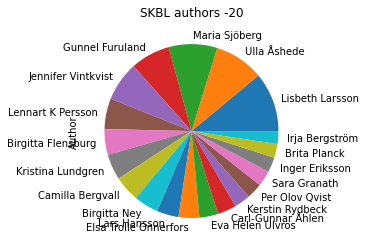

In [13]:
plotPublishedAuthor = SKBLtot  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors -20")
plt.show()

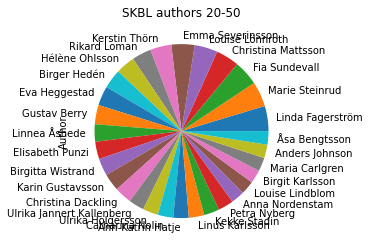

In [14]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors 20-50")
plt.show()

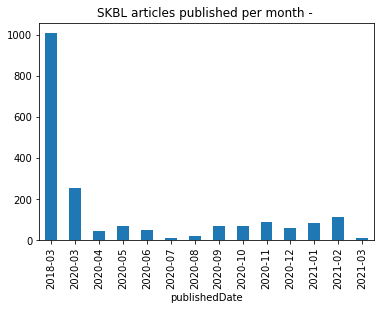

<Figure size 1600x2400 with 0 Axes>

In [15]:
from matplotlib.pyplot import figure
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = SKBLtot['publishedDate'].groupby(SKBLtot.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month - ")
plt.savefig('SKBLBarpublished.png') 
figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')
plt.show()

In [16]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      67
2020-10      70
2020-11      89
2020-12      59
2021-01      82
2021-02     112
2021-03      13
Freq: M, Name: publishedDate, dtype: int64

In [17]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      67
2020-10      70
2020-11      89
2020-12      59
2021-01      82
2021-02     112
2021-03      13
Freq: M, Name: publishedDate, dtype: int64

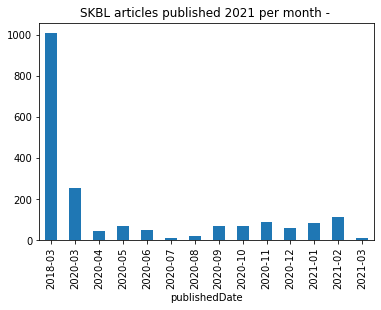

<Figure size 1600x2400 with 0 Axes>

In [18]:
plotPublishedperMonth2020 = SKBLtot['publishedDate'].groupby(SKBLtot.publishedDate.dt.to_period("M")).agg('count')

plotPublishedperMonth2020.plot( kind = 'bar') 
plt.title("SKBL articles published 2021 per month - ")
plt.savefig('SKBL2020Barpublished.png') 
figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')
plt.show()

In [19]:
plotPublishedperMonth.sum()

1956

In [20]:
print("Nr articles left to the goal 2000 = ",2000- plotPublishedperMonth.sum())

Nr articles left to the goal 2000 =  44


In [21]:
#plotPublishedAccumalted

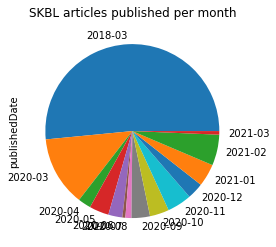

In [22]:
plotPublishedperMonth.plot( kind = 'pie') 
plt.title("SKBL articles published per month") 
plt.savefig('SKBLPiepublished.png')
plt.show()

In [23]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [24]:
from IPython.display import display, HTML  

plotPublishedAuthor["Link"] = "<a href='https://skbl.se/sv/artikel/" + plotPublishedAuthor['skblid'].astype(str) + "'>SKBL web</a>"
plotPublishedAuthor["Linkjson"] = "<a href='https://skbl.se/sv/artikel/" + plotPublishedAuthor['skblid'].astype(str) + ".json'>SKBL Json</a>"

# Merge plotPublishedAuthor WDSKBLtot  
mergeSKBLWD = pd.merge(WDSKBLtot, plotPublishedAuthor,how='outer', on='skblid',indicator=True)   
mergeSKBLWD.rename(columns={"_merge": "WD_SKBL"},inplace = True)
mergeSKBLWD['WD_SKBL'] = mergeSKBLWD['WD_SKBL'].str.replace('left_only','WD_only').str.replace('right_only','SKBL_only')
mergeSKBLWD["WD_SKBL"].value_counts()  


both         1901
SKBL_only      55
WD_only         1
Name: WD_SKBL, dtype: int64

In [25]:
mergeSKBLWD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957 entries, 0 to 1956
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   WikidataID                1902 non-null   object        
 1   skblid                    1957 non-null   object        
 2   en                        838 non-null    object        
 3   sv                        1715 non-null   object        
 4   Source_x                  1902 non-null   object        
 5   publishedDate             1956 non-null   datetime64[ns]
 6   article_author_firstname  1956 non-null   object        
 7   article_author_lastname   1956 non-null   object        
 8   subtitle_sv               1956 non-null   object        
 9   name_lastname             1956 non-null   object        
 10  name_firstname            1956 non-null   object        
 11  born                      1956 non-null   object        
 12  death               

# Latest articles published in SKBL

In [26]:
#mergeSKBLWD.info()

In [27]:
# de sista 10 publiserade biografier 
mergeSKBLWD = mergeSKBLWD.sort_values(by=['publishedDate'], ascending=[False])
mergeSKBLWD = mergeSKBLWD.reset_index(drop=True)  
mergeSKBLWD["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + mergeSKBLWD['WikidataID'].astype(str) + "'>Wikidata</a>"
mergeSKBLWD["svWikipedia"] = "<a href='https://www.wikidata.org/wiki/Special:GoToLinkedPage/svwiki/" + mergeSKBLWD['WikidataID'].astype(str) + "'>svWiki</a>"
#mergeSKBLWD["enWikipedia"] = "<a href='" + mergeSKBLWD['en'].astype(str) + "'>enWiki</a>"

HTML(mergeSKBLWD[{'publishedDate','internal_comment','WikidataID','Wikidata','skblid','subtitle_sv','WD_SKBL','Link','Linkjson','svWikipedia','en','sv'}][:10].to_html(escape=False))


,Wikidata,publishedDate,en,Linkjson,WikidataID,Link,WD_SKBL,sv,svWikipedia,internal_comment,skblid,subtitle_sv
0,Wikidata,2021-03-04,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,Saknar ISNI; LÅ;,BritaSkotsner,Fotograf
1,Wikidata,2021-03-04,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,Saknar ISNI; LÅ;,TillieAnderson,"Idrottare, cyklist, pionjär"
2,Wikidata,2021-03-04,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ; porträttsök pågår,MarieLouiseBachman,"Bibliotekarie, historiker, pionjär"
3,Wikidata,2021-03-04,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ; porträttsök pågår,BeataBergstrom,"Teaterfotograf, pionjär"
4,Wikidata,2021-03-04,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ; porträttsök pågår,IngerRudberg0,"Lärare, folkbildare, debattör"
5,Wikidata,2021-03-03,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,"LÅ; OBS: jag utelämnade ""Långa Lappflickan"" bland namnen av samma orsak som jag utelämnade ""Svarta Sara"" om Mazahr Makatemele, och vi fick byta namn på ""Margareta lappkvinna"" till ""Margareta, missionär"".",ChristinaCatharinaLarsdotter,"Flicka med gigantism, utställningsartist"
6,Wikidata,2021-03-03,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ;,MariaMarySofiaAnderson,"Facklig ledare, kvinnosakskvinna"
7,Wikidata,2021-03-03,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,Saknar ISNI; LÅ;,EllyBertaIsabellaLofstrand,"Gymnast, pionjär, folkbildare"
8,Wikidata,2021-03-03,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ; porträtt saknas,MirjamFuruhjelm,"Gynekolog, professor, pionjär"
9,Wikidata,2021-03-02,NaN,SKBL Json,NaN,SKBL web,SKBL_only,NaN,svWiki,LÅ;,IngridYlvaBirgittaKallstromEklund,"Tecknare, illustratör, grafisk formgivare"


In [28]:
#mergeSKBLWDOVRST = mergeSKBLWD[mergeSKBLWD["internal_comment"].str.contains("ÖVRST")].copy() 
#TBD filter en 20201221
#HTML(mergeSKBLWDOVRST[{'publishedDate','internal_comment','skblid','subtitle_sv','WD_SKBL','Link','Linkjson','svWikipedia','en','sv'}][:50].to_html(escape=False))


In [29]:
#Get öatest translated add date for ÖVRST
#temp = mergeSKBLWD[mergeSKBLWD["internal_comment"].str.contains("2021")].copy() 
#HTML(temp[{'publishedDate','internal_comment','skblid','subtitle_sv','WD_SKBL','Link','Linkjson','svWikipedia','en'}][:50].to_html(escape=False))


## Compare SBL
SBL started in 1918 and is published by the [National Archives](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually been adding links but also tried doing webscrabing to populate [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883) Oct 30 2019, 11:03 AM - no official answer so far and The Swedish National Archives has no helpdesk system were you get an unique helpdesk number ([some action was promised aug 2018 by Rolf Källman](https://twitter.com/salgo60/status/1030269242296414208?s=20) nothing heard)

### Wikidata <-> SBL updated
We did a NEW try getting structure from webscrabed data see [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) as SBL is non structured data we will get errors and also problem understand what is an article about a family and what is about a person.... 

In [30]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?sblid  ?skblid ?genderLabel  WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
?item wdt:P3217 ?sblid
OPTIONAL {?item wdt:P4963 ?skblid}
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
#WDSBLtot.info()

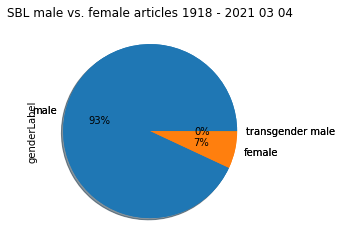

In [31]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.title("Riksarkivet SBL male/female")
plot = plotSBLgender.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL male vs. female articles 1918 - " + start_time.strftime('%Y %m %d'))
plt.savefig('SBLmalefemale.png')
plt.show()

In [32]:
plotSBLgender

male                7069
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [33]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7597 entries, 0 to 7596
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   WikidataID   7597 non-null   object
 1   sblid        7597 non-null   object
 2   skblid       377 non-null    object
 3   genderLabel  7597 non-null   object
 4   Source       7597 non-null   object
dtypes: object(5)
memory usage: 296.9+ KB


In [34]:
WDSBLtot[WDSBLtot.duplicated(subset=['WikidataID'])]

,WikidataID,sblid,skblid,genderLabel,Source


In [35]:
plotSBLgender

male                7069
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [36]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
#plotSBLfemale.info() 

In [37]:
end = datetime.now()
print("Ended: ", end)

Ended:  2021-03-04 15:23:54.506759


In [38]:
dfmerge = pd.merge(plotSBLfemale, mergeSKBLWD,how='outer', on='WikidataID',indicator=True)

In [39]:
#dfmerge.info()

In [40]:
dfmerge["_merge"].value_counts()

right_only    1581
both           376
left_only      151
Name: _merge, dtype: int64

In [41]:
# both is number in bioth SBL and SKBL   
# right_only is SBL
# left_only is SKBL

In [42]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','SBL_only').str.replace('right_only','SKBL_only')
dfmerge.rename(columns={"_merge": "SBL_SKBL"},inplace = True)

#dfmerge[0:10]  


In [43]:
mergeCheck = dfmerge[['WikidataID', 'sblid','skblid_x','publishedDate','SBL_SKBL']] 
mergeCheck.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 0 to 2107
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     2053 non-null   object        
 1   sblid          527 non-null    object        
 2   skblid_x       376 non-null    object        
 3   publishedDate  1956 non-null   datetime64[ns]
 4   SBL_SKBL       2108 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 98.8+ KB


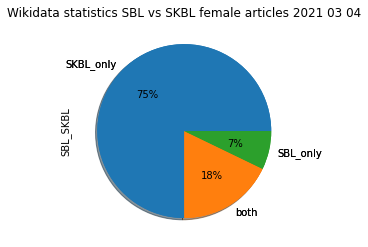

In [44]:
mergeCheckNumber = mergeCheck["SBL_SKBL"].value_counts()
mergeCheckNumber.plot( kind = 'pie')  
plot = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("Wikidata statistics SBL vs SKBL female articles " + start_time.strftime('%Y %m %d'))
plt.savefig('SKBLSBLfemale.png')
plt.show()


In [45]:
mergeCheckNumber

SKBL_only    1581
both          376
SBL_only      151
Name: SBL_SKBL, dtype: int64

In [46]:
#Profiles missing in SKBL that SBL has written = left_only 
WDSBLonly = mergeCheck[mergeCheck["SBL_SKBL"] == "SBL_only"].copy() 

In [47]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 7 to 523
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     151 non-null    object        
 1   sblid          151 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       151 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 7.1+ KB


In [48]:
WDSBLonly["sbl"] = "<a href='https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=" + WDSBLonly['sblid'].astype(str) + "'>SBL web</a>"
WDSBLonly["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + WDSBLonly['WikidataID'].astype(str) + "'>Wikidata</a>"

pd.set_option('column_space', 20)
pd.set_option('max_colwidth', 300)
#List new SKBL articles not in Wikidata
pd.set_option("display.max.columns", None) 
HTML(WDSBLonly[{'WikidataID','Wikidata','sblid','sbl'}].tail(15).to_html(escape=False))

,Wikidata,sblid,WikidataID,sbl
486,Wikidata,9095,Q262305,SBL web
487,Wikidata,9096,Q1991150,SBL web
492,Wikidata,9101,Q4965627,SBL web
493,Wikidata,9103,Q622833,SBL web
494,Wikidata,9105,Q61475,SBL web
495,Wikidata,9106,Q233319,SBL web
496,Wikidata,9107,Q3847259,SBL web
497,Wikidata,9109,Q235438,SBL web
499,Wikidata,9243,Q4966895,SBL web
501,Wikidata,9294,Q3307503,SBL web


### Same query in Wikidata 
* Find all women [in SBL but not in SKBL](https://w.wiki/bFw) < 190 women
* Find all women [in SBL but not in SKBL and have an en:Wikipedia article](https://w.wiki/bFy) = 123 
### Wikipedia articles linking SKBL 
* sv:Wikipedia [usage template Authority](https://sv.wikipedia.org/wiki/Kategori:Wikipediaartiklar_med_identifierare_fr%C3%A5n_SKBL) > 1460
  * **[Issue 23](https://github.com/spraakbanken/skbl-portal/issues/23)** SKBL has no date when the article is  translated maybe bad "workaround" is check tag **text_eng** that is missing in a non translated article as [JosephineGabrielleMarcelleMeunierSainteClaire.json](https://skbl.se/sv/artikel/JosephineGabrielleMarcelleMeunierSainteClaire.json) compare translated [article](https://skbl.se/sv/artikel/JennyLind.json) and then check that all articles with **text_eng** has [template SBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963)
* en:Wikipedia [usage template SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 686 articles

### Lists related to SKBL
* en:Wikipedia [Women in Red SKBL](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) list with articles "missing" in en:Wikipedia but in SKBL
* sv:Wikipedia [articles missing](https://w.wiki/Zun) but in SKBL


In [49]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 7 to 523
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     151 non-null    object        
 1   sblid          151 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       151 non-null    object        
 5   sbl            151 non-null    object        
 6   Wikidata       151 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 9.4+ KB


In [50]:
dfmerge["SBL_SKBL"].value_counts()

SKBL_only    1581
both          376
SBL_only      151
Name: SBL_SKBL, dtype: int64

In [51]:
mergeSKBLWD["WD_SKBL"].value_counts() 

both         1901
SKBL_only      55
WD_only         1
Name: WD_SKBL, dtype: int64

In [52]:
#List new SKBL articles not in Wikidata
mergeSKBLWD_WDOnly = mergeSKBLWD[mergeSKBLWD["WD_SKBL"] == "SKBL_only"].copy() 
mergeSKBLWD_WDOnly["linkjson"] = "<a href='https://www.skbl.se/sv/artikel/" + mergeSKBLWD_WDOnly["skblid"].astype(str) + ".json'>json</a>"
mergeSKBLWD_WDOnly["linkhtml"] = "<a href='https://www.skbl.se/sv/artikel/" + mergeSKBLWD_WDOnly["skblid"].astype(str) + "'>html</a>"
mergeSKBLWD_WDOnly["newWdref"] = "<a href='https://quickstatements.toolforge.org/#/v1=WDOBJEKT%7CP1343%7CQ50395049%7CP407%7CQ9027%7CP407%7CQ1860%7CS4963%7C%22" + \
                                  mergeSKBLWD_WDOnly["skblid"].astype(str) + "%22'>QS</a>"
#                                  "%7CP1343%7C" + mergeSKBLWD_WDOnly["skblid"].astype(str) +  "%22'>QS</a>"
                                  
pd.set_option("display.max.columns", None) 


In [53]:
mergeSKBLWD_WDOnly.sample()

,WikidataID,skblid,en,sv,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,born,death,internal_comment,Source_y,Author,Link,Linkjson,WD_SKBL,Wikidata,svWikipedia,linkjson,linkhtml,newWdref
53,NaN,EstherRoeckHansen,NaN,NaN,NaN,2021-02-19,Jennifer,Vintkvist,Skådespelare,Roeck-Hansen,Ester (/Esther/) Linéa,1897-08-12,1987-06-14,Saknar ISNI; LÅ;,SKBL,Jennifer Vintkvist,<a href='https://skbl.se/sv/artikel/EstherRoeckHansen'>SKBL web</a>,<a href='https://skbl.se/sv/artikel/EstherRoeckHansen.json'>SKBL Json</a>,SKBL_only,<a href='https://www.wikidata.org/wiki/nan'>Wikidata</a>,<a href='https://www.wikidata.org/wiki/Special:GoToLinkedPage/svwiki/nan'>svWiki</a>,<a href='https://www.skbl.se/sv/artikel/EstherRoeckHansen.json'>json</a>,<a href='https://www.skbl.se/sv/artikel/EstherRoeckHansen'>html</a>,<a href='https://quickstatements.toolforge.org/#/v1=WDOBJEKT%7CP1343%7CQ50395049%7CP407%7CQ9027%7CP407%7CQ1860%7CS4963%7C%22EstherRoeckHansen%22'>QS</a>


## New SKBL records
missing in Wikidata

In [54]:
mergeSKBLWD_WDOnly.shape

(55, 24)

In [55]:
#Display 10
HTML(mergeSKBLWD_WDOnly[{'WikidataID','skblid','publishedDate','linkjson','linkhtml','newWdref'}].tail(100).to_html(escape=False))

,publishedDate,WikidataID,skblid,newWdref,linkhtml,linkjson
0,2021-03-04,NaN,BritaSkotsner,QS,html,json
1,2021-03-04,NaN,TillieAnderson,QS,html,json
2,2021-03-04,NaN,MarieLouiseBachman,QS,html,json
3,2021-03-04,NaN,BeataBergstrom,QS,html,json
4,2021-03-04,NaN,IngerRudberg0,QS,html,json
5,2021-03-03,NaN,ChristinaCatharinaLarsdotter,QS,html,json
6,2021-03-03,NaN,MariaMarySofiaAnderson,QS,html,json
7,2021-03-03,NaN,EllyBertaIsabellaLofstrand,QS,html,json
8,2021-03-03,NaN,MirjamFuruhjelm,QS,html,json
9,2021-03-02,NaN,IngridYlvaBirgittaKallstromEklund,QS,html,json


In [56]:
#SKBLtot.info() 
#SKBLtot[SKBLtot['skblid'].str.contains("AlmaIsabelSofiaHedin")] 
#df['Position'].str.contains("PG")
#Missing in Wikidata    

mergeSKBLWD_WDOnly[{"skblid","publishedDate","subtitle_sv"}]

,publishedDate,skblid,subtitle_sv
0,2021-03-04,BritaSkotsner,Fotograf
1,2021-03-04,TillieAnderson,"Idrottare, cyklist, pionjär"
2,2021-03-04,MarieLouiseBachman,"Bibliotekarie, historiker, pionjär"
3,2021-03-04,BeataBergstrom,"Teaterfotograf, pionjär"
4,2021-03-04,IngerRudberg0,"Lärare, folkbildare, debattör"
5,2021-03-03,ChristinaCatharinaLarsdotter,"Flicka med gigantism, utställningsartist"
6,2021-03-03,MariaMarySofiaAnderson,"Facklig ledare, kvinnosakskvinna"
7,2021-03-03,EllyBertaIsabellaLofstrand,"Gymnast, pionjär, folkbildare"
8,2021-03-03,MirjamFuruhjelm,"Gynekolog, professor, pionjär"
9,2021-03-02,IngridYlvaBirgittaKallstromEklund,"Tecknare, illustratör, grafisk formgivare"


In [57]:
mergeSKBLWD_WDOnly[{"skblid","publishedDate","subtitle_sv"}].to_csv("SKBL_new.csv")

* See latest checked [SKBL_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/SKBL_new.csv)

In [58]:
mergeSKBLWD_WDOnly.shape

(55, 24)

In [59]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2021-03-04 15:23:54.882600
Time elapsed (hh:mm:ss.ms) 0:00:19.212210


### more links 
  * this [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) [tinyurl.com/SKBLSBL](https://tinyurl.com/SKBLSBL)
    * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL - obsolete is done in this Notebook 
    * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
    * [part 4](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%204.ipynb) test extract archives
    * [part 5](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%205.ipynb) check Uppsala University Alvin
    * [SKBL issue board](https://github.com/spraakbanken/skbl-portal/issues) on GitHub
      * open [SKBL 23](https://github.com/spraakbanken/skbl-portal/issues/23) field when translated
      * 
  * [Möte 2020 dec](https://phabricator.wikimedia.org/T269498)
  